## Installing and Importing Packages

In [1]:
# %pip install langid

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from wordcloud import WordCloud
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
import spacy_fastlang
from nltk.corpus import stopwords, wordnet
from collections import Counter
import re
from symspellpy import SymSpell
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from bs4 import BeautifulSoup
from emojii_and_emoticon_map import EMOTICONS_EMO, EMOJI_UNICODE
from nltk.tokenize import word_tokenize
import contractions
import string
import langid
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, pos_tag_sents
from textstat import textstat
from nltk import bigrams, trigrams, FreqDist
from sklearn_deltatfidf import DeltaTfidfVectorizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [3]:
warnings.filterwarnings('ignore')
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("language_detector")
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

## Loading the data

In [4]:
df = pd.read_csv("training_data.csv", index_col="Unnamed: 0")
df.reset_index(drop=True, inplace=True)
df.head()

,overall_rating,review_date,review_text,airline_name
0,Rated 1 out of 5 stars,"Monday, September 18, 2023 at 03:29:15 AM",EasyJet sent text at 4.00 am day of flight hom...,easyjet
1,9,December 2023,Its been a few years when I flew a lot in A...,Vistara
2,Rated 5 out of 5 stars,"Wednesday, September 6, 2023 at 01:58:27 AM",Useful,volotea
3,Rated 1 out of 5 stars,"Sunday, September 9, 2018 at 08:37:11 PM",one of the worst experiences with Air France e...,air france
4,Rated 1 out of 5 stars,"Monday, December 23, 2019 at 02:00:19 PM",Not a single star this airlines deserves .I lo...,egyptair


## Exploratory Data Analysis

In [5]:
df.shape

(65742, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65742 entries, 0 to 65741
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall_rating  65742 non-null  object
 1   review_date     65742 non-null  object
 2   review_text     65742 non-null  object
 3   airline_name    65718 non-null  object
dtypes: object(4)
memory usage: 2.0+ MB


overall_rating     0
review_date        0
review_text        0
airline_name      24
dtype: int64


<Axes: >

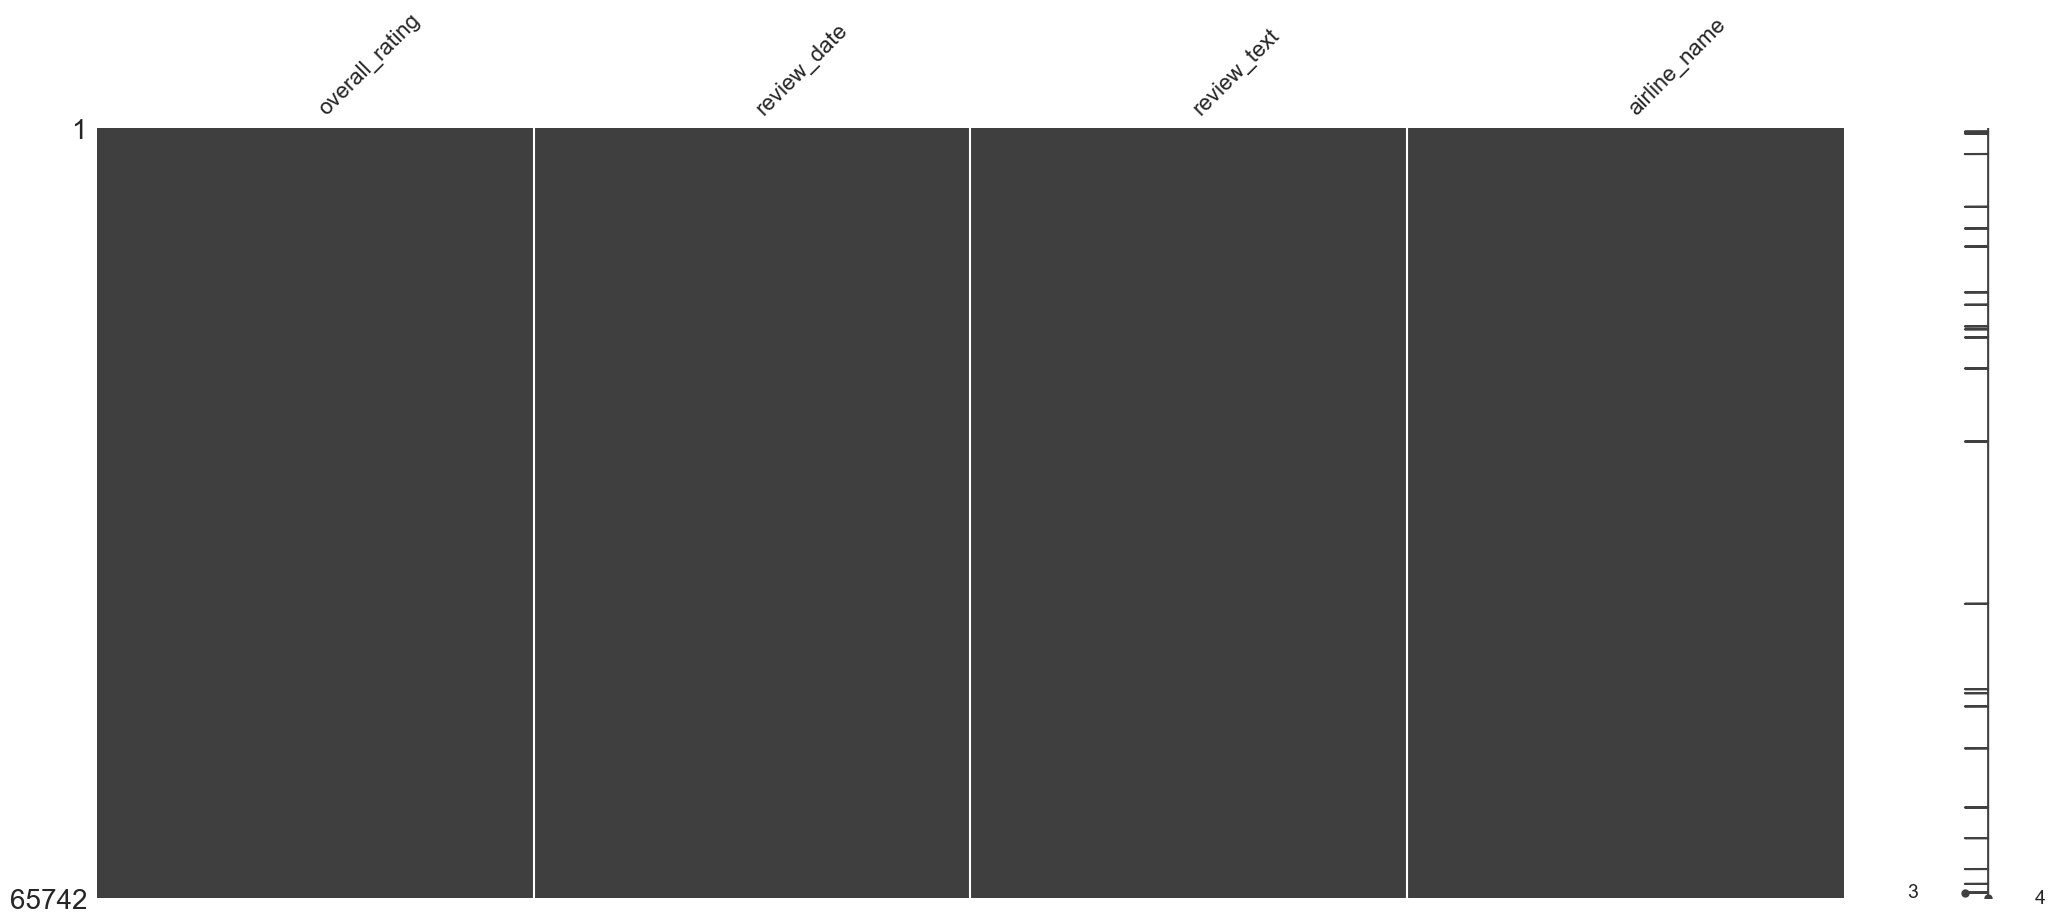

In [7]:
import missingno as msno

print(df.isna().sum())

%matplotlib inline
display(msno.matrix(df))

In [8]:
df.dropna(inplace=True)

In [9]:
dup_values = df.duplicated(keep=False)
df[dup_values].sort_values(by="review_text").tail(7)

,overall_rating,review_date,review_text,airline_name
20529,Rated 2 out of 5 stars,"Sunday, October 8, 2023 at 07:13:48 PM",İ had two flight with British Airways . İn bot...,british airways
2230,Rated 2 out of 5 stars,"Sunday, October 8, 2023 at 07:13:48 PM",İ had two flight with British Airways . İn bot...,british airways
34063,Rated 2 out of 5 stars,"Sunday, October 8, 2023 at 07:13:48 PM",İ had two flight with British Airways . İn bot...,british airways
32209,Rated 1 out of 5 stars,"Wednesday, April 19, 2023 at 11:24:49 PM",“We don’t have a magic stick for lost bags sir...,british airways
43678,Rated 1 out of 5 stars,"Wednesday, April 19, 2023 at 11:24:49 PM",“We don’t have a magic stick for lost bags sir...,british airways
29373,Rated 1 out of 5 stars,"Saturday, October 7, 2023 at 05:30:08 AM",…\nwould give no stars if i could booked a hol...,ryanair
60694,Rated 1 out of 5 stars,"Saturday, October 7, 2023 at 05:30:08 AM",…\nwould give no stars if i could booked a hol...,ryanair


In [10]:
df.drop_duplicates(inplace=True)

From first glance it can be seen that overall_rating and review_date are of different formats. The formatting for these must be standardized

In [11]:
df["overall_rating"].unique() # unique values for rating

array(['Rated 1 out of 5 stars', '9', 'Rated 5 out of 5 stars',
       'Rated 4 out of 5 stars', '1', 'Rated 3 out of 5 stars',
       'Rated 2 out of 5 stars', '1.0', '2', '10.0', '4.0', '8', '9.0',
       '0.0', '3', '3.0', '4', '2.0', '6', '7', '5.0', '5', '8.0', '6.0',
       '7.0', '10'], dtype=object)

Based on the data scraped the datasets from airline reviews and skytrax are on a 10 point rating while the ones on trustpilot are on a 5 point rating. The main objective is to see whether given a text, the person is likely to be a promoter, detractor or passive of the airline. 

In [12]:
# looking at 1 star
print(df.loc[df["overall_rating"] == "Rated 1 out of 5 stars"]["review_text"].iloc[0])
print("============================================================================================")
# looking at 2 star
print(df.loc[df["overall_rating"] == "Rated 2 out of 5 stars"]["review_text"].iloc[0])
print("============================================================================================")
# looking at 3 star
print(df.loc[df["overall_rating"] == "Rated 3 out of 5 stars"]["review_text"].iloc[0])
print("============================================================================================")
# looking at 4 star
print(df.loc[df["overall_rating"] == "Rated 4 out of 5 stars"]["review_text"].iloc[0])
print("============================================================================================")
# looking at 5 star
print(df.loc[df["overall_rating"] == "Rated 5 out of 5 stars"]["review_text"].iloc[0])
print("============================================================================================")

EasyJet sent text at 4.00 am day of flight home cancelling flight.
Left to rush round organising new flight, transport and hotel.
Huge effort and implications.
Seems EasyJet could not care less.
Never pre-register your credit card! I did and they deducted $68 for double gin and glass of wine. I ordered tonic water and got seltzer!
Some of the emirates services need to be improved
Best service and luxury service of costumers... Hope we are soon to fly again ;)
Useful


Based on this sample text, it can be said that 1 and 2 stars are detractors showing clear frustration with the airline service. 3 star seems more neutral, they enjoyed certain parts but there were parts where they didnt. 4 and 5 star feel more positive and that the person enjoyed their experience

In [13]:
def classify_nps(rating_text):
    rating_text = rating_text.strip()
    if "Rated" in rating_text:
        rating = int(rating_text.split(' ')[1])
        return "Detractor" if rating <= 2 else ("Neutral" if rating == 3 else "Promoter")
    else:
        rating = int(float(rating_text))
        return "Detractor" if rating <= 6 else ("Neutral" if rating <= 8 else "Promoter")
        
print(classify_nps("7"))
print(classify_nps("Rated 4 out of 5 stars"))

Neutral
Promoter


In [14]:
df["NPS_category"] = df["overall_rating"].apply(classify_nps)
df.head()

,overall_rating,review_date,review_text,airline_name,NPS_category
0,Rated 1 out of 5 stars,"Monday, September 18, 2023 at 03:29:15 AM",EasyJet sent text at 4.00 am day of flight hom...,easyjet,Detractor
1,9,December 2023,Its been a few years when I flew a lot in A...,Vistara,Promoter
2,Rated 5 out of 5 stars,"Wednesday, September 6, 2023 at 01:58:27 AM",Useful,volotea,Promoter
3,Rated 1 out of 5 stars,"Sunday, September 9, 2018 at 08:37:11 PM",one of the worst experiences with Air France e...,air france,Detractor
4,Rated 1 out of 5 stars,"Monday, December 23, 2019 at 02:00:19 PM",Not a single star this airlines deserves .I lo...,egyptair,Detractor


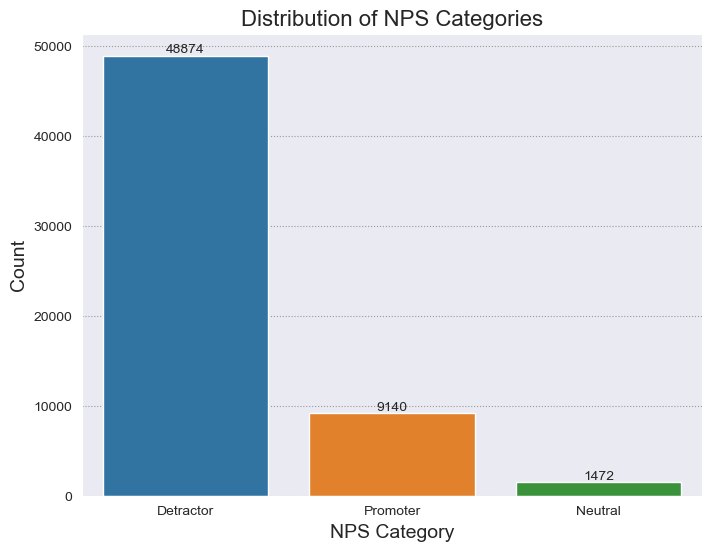

In [15]:
plt.figure(figsize=(8, 6))
plot = sns.countplot(data=df, x="NPS_category")
plot.bar_label(plot.containers[0])

plot.set_xlabel("NPS Category", fontsize=14)
plot.set_ylabel("Count", fontsize=14)

plt.title("Distribution of NPS Categories", fontsize=16)
plt.show()

Significant class imbalance that needs to be looked at. Techniques such as stratify + class weighting, oversampling and undersampling can be looked at to ensure that the classes are balanced and that the models do not show any kind of bias against a particular class

In [16]:
date_formats = ["%B %Y", "%B %d, %Y", "%A, %B %d, %Y at %I:%M:%S %p"]

def parse_and_standardize_date(date_str):
    for fmt in date_formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return None

df["review_date"] = df["review_date"].apply(parse_and_standardize_date)

In [17]:
df.describe().T

,count,mean,min,25%,50%,75%,max
review_date,59486,2021-11-03 13:26:12.674174976,2010-07-14 23:06:06,2020-09-11 03:32:59,2022-07-07 04:51:42,2023-06-12 01:52:05.500000,2024-01-27 07:14:11


We have a large range of data from 2010 all the way to 2024, with majority of the reviews following in recent years (2021 to 2024)

<Figure size 1200x600 with 0 Axes>

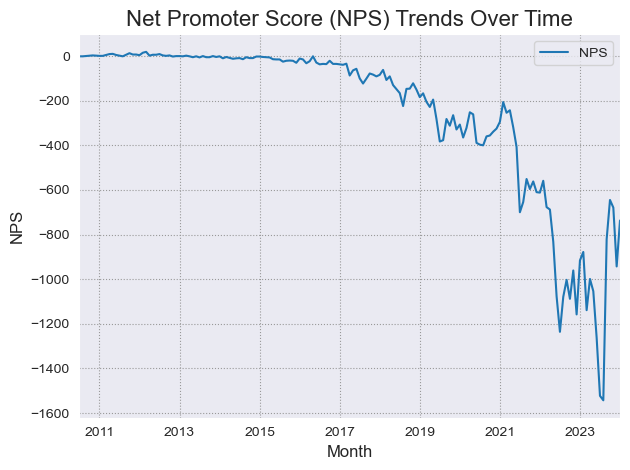

In [18]:
def calculate_nps(row):
    if row['NPS_category'] == 'Promoter':
        return 1
    elif row['NPS_category'] == 'Detractor':
        return -1
    else:
        return 0

df['NPS'] = df.apply(calculate_nps, axis=1)

nps_trends = df.groupby(df['review_date'].dt.to_period("M"))['NPS'].sum().reset_index()
nps_trends = nps_trends.set_index('review_date')
plt.figure(figsize=(12, 6));
nps_trends.plot();
plt.title('Net Promoter Score (NPS) Trends Over Time', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('NPS', fontsize=12)
plt.tight_layout()
plt.show()

It can be seen that the overall Net promoter score (NPS) is decreasing over the years which shows that the quality/service of the airlines has been declining.

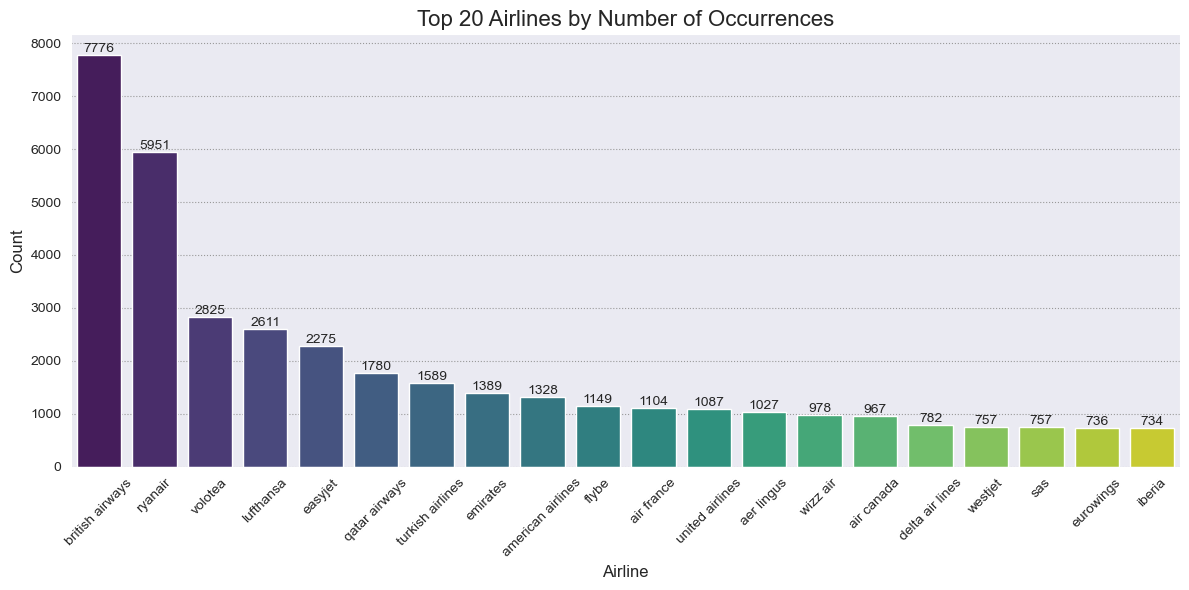

In [19]:
airline_counts = df["airline_name"].value_counts().head(20)

plt.figure(figsize=(12, 6))
plot = sns.barplot(x=airline_counts.index, y=airline_counts.values, palette='viridis')
plot.bar_label(plot.containers[0])
plt.title('Top 20 Airlines by Number of Occurrences', fontsize=16)
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most of the reviews are from british airways, ryan air and volotea.

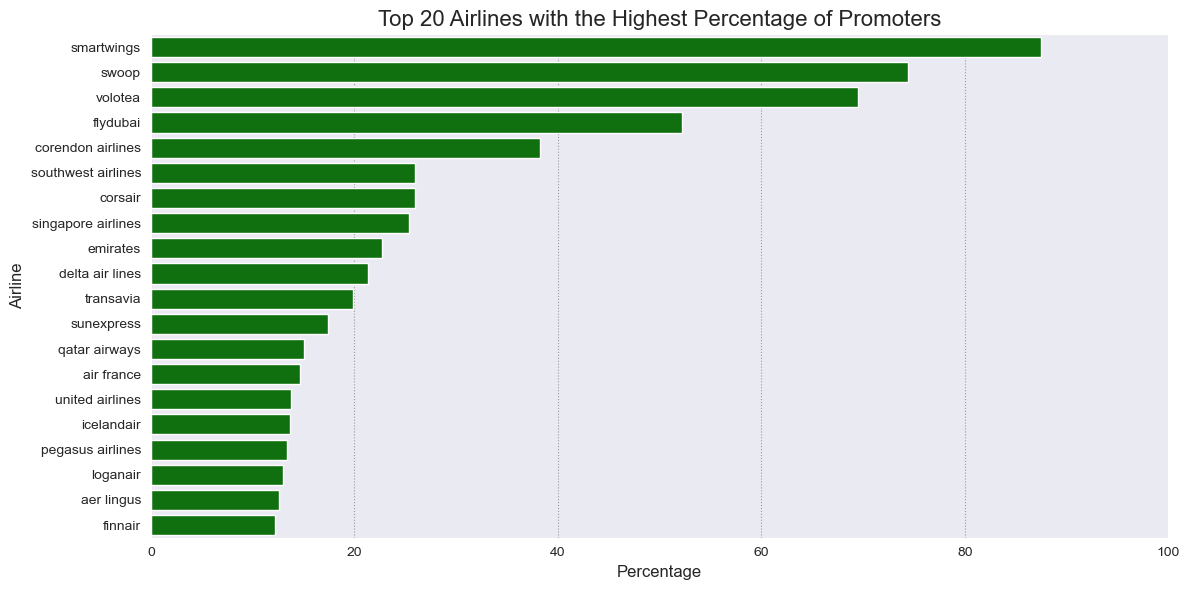

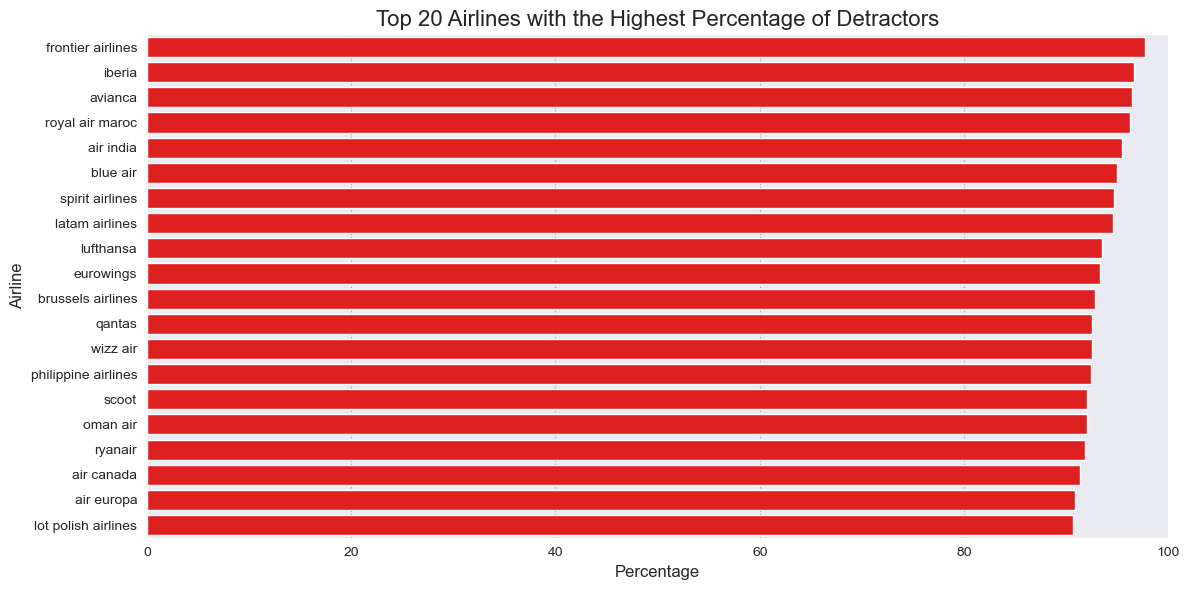

In [20]:
nps_counts = df.groupby(['airline_name', 'NPS_category']).size().unstack(fill_value=0)

threshold_reviews = 200
filtered_airlines = nps_counts[(nps_counts['Promoter'] + nps_counts['Detractor']) >= threshold_reviews]

top_20_promoters_percent = (filtered_airlines['Promoter'] / (filtered_airlines['Promoter'] + filtered_airlines['Detractor'])).sort_values(ascending=False).head(20)
top_20_detractors_percent = (filtered_airlines['Detractor'] / (filtered_airlines['Promoter'] + filtered_airlines['Detractor'])).sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_promoters_percent.values * 100, y=top_20_promoters_percent.index, color='green')
plt.title('Top 20 Airlines with the Highest Percentage of Promoters', fontsize=16)
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Airline', fontsize=12)
plt.xlim(0, 100)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_detractors_percent.values * 100, y=top_20_detractors_percent.index, color='red')
plt.title('Top 20 Airlines with the Highest Percentage of Detractors', fontsize=16)
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Airline', fontsize=12)
plt.xlim(0, 100)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

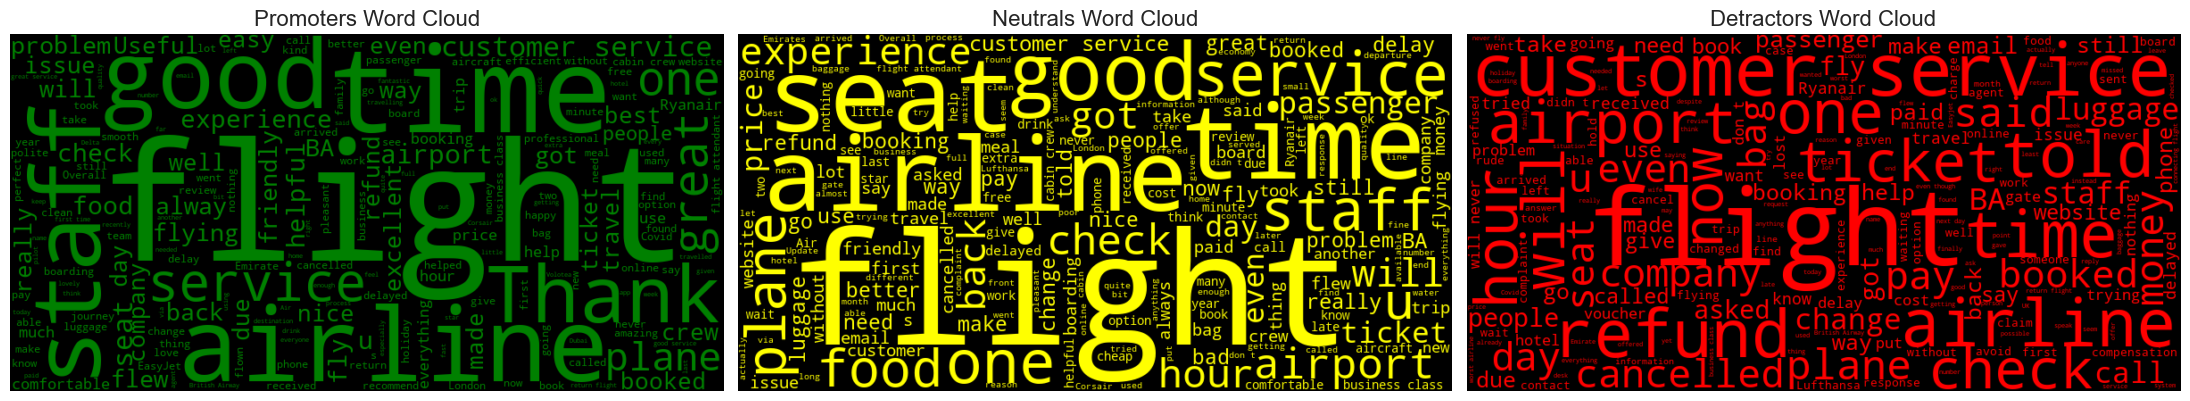

In [21]:
# Create separate DataFrames for Promoters, Detractors, and Neutrals
promoters_df = df[df['NPS_category'] == 'Promoter']
detractors_df = df[df['NPS_category'] == 'Detractor']
neutrals_df = df[df['NPS_category'] == 'Neutral']

def generate_word_cloud(dataframe, title, num, text_color, background_color):
    text = ' '.join(dataframe['review_text'])
    wordcloud = WordCloud(
        width=800, height=400, background_color=background_color,
        colormap='viridis', color_func=lambda *args, **kwargs: text_color
    ).generate(text)
    plt.subplot(num)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)

plt.figure(figsize=(22, 10))

generate_word_cloud(promoters_df, 'Promoters Word Cloud', 131, 'green', 'black')
generate_word_cloud(neutrals_df, 'Neutrals Word Cloud', 132, 'yellow', 'black')
generate_word_cloud(detractors_df, 'Detractors Word Cloud', 133, 'red', 'black')

plt.tight_layout()
plt.show()

There are a lot of words that are repeated across all the word clouds like flight, time, airline, etc. These are considered as stopwords and need to be removed from the corpus as they do not add any value to the text. The same wordcloud will be created again later on in the notebook after cleaning the text to better show the topics that contribute to promoter, neutrals and detractors. 

In [22]:
df.head()

,overall_rating,review_date,review_text,airline_name,NPS_category,NPS
0,Rated 1 out of 5 stars,2023-09-18 03:29:15,EasyJet sent text at 4.00 am day of flight hom...,easyjet,Detractor,-1
1,9,2023-12-01 00:00:00,Its been a few years when I flew a lot in A...,Vistara,Promoter,1
2,Rated 5 out of 5 stars,2023-09-06 01:58:27,Useful,volotea,Promoter,1
3,Rated 1 out of 5 stars,2018-09-09 20:37:11,one of the worst experiences with Air France e...,air france,Detractor,-1
4,Rated 1 out of 5 stars,2019-12-23 14:00:19,Not a single star this airlines deserves .I lo...,egyptair,Detractor,-1


Now that there is a better understanding of the dataset, its time to move onto the data preparation.

## Data Preparation

First step is to identify the language of the text. For this project the main focus will be on the english language. Other language texts will be removed.

In [23]:
def detect_language(text):
    lang, _ = langid.classify(text)
    return lang

tqdm.pandas(desc="Detecting languages")
df['language_info'] = df['review_text'].progress_apply(detect_language)
df.loc[df["language_info"] != "en"]

Detecting languages: 100%|███████████████| 59486/59486 [02:27<00:00, 402.14it/s]


,overall_rating,review_date,review_text,airline_name,NPS_category,NPS,language_info
91,Rated 5 out of 5 stars,2023-09-04 22:38:42,A great airline,volotea,Promoter,1,fr
145,Rated 1 out of 5 stars,2023-09-16 05:19:16,Me cobraron un plus no consentido y no he cons...,volotea,Detractor,-1,es
157,Rated 1 out of 5 stars,2021-11-23 00:33:48,"FIRST OF ALL, I DONT RECOMENDD ANYONE TO FLY W...",turkish airlines,Detractor,-1,no
363,Rated 2 out of 5 stars,2018-10-06 16:47:12,Service client absolument pas à l’écoute des c...,aigle azur,Detractor,-1,fr
826,Rated 1 out of 5 stars,2023-05-19 21:12:11,60 eur fee cause i didn't check in online. Dis...,ryanair,Detractor,-1,it
...,...,...,...,...,...,...,...
65135,1.0,2016-10-17 00:00:00,Worst experience ever.,Air Seychelles,Detractor,-1,fr
65147,Rated 1 out of 5 stars,2023-04-09 08:10:42,Vol annulé et la compagnie Ne veut pas m’indem...,swiss international air lines,Detractor,-1,fr
65515,Rated 5 out of 5 stars,2023-08-31 21:43:00,Fantastisk oplevelse. Der var masser af benpla...,alsie express,Promoter,1,da
65517,Rated 5 out of 5 stars,2024-01-15 02:45:55,Parfait en tout point.,volotea,Promoter,1,fr


In [24]:
_max = df.language_info.value_counts().max()
_min = df.language_info.value_counts().min()
def make_pretty(styler):
    styler.set_caption("Language counts")
    styler.background_gradient(axis=None, vmin=_min, vmax=_max, cmap="YlGnBu")
    return styler

df.language_info.value_counts().to_frame().T.style.pipe(make_pretty)

language_info,en,fr,es,it,de,no,da,nl,la,pt,ru,sv,mt,ca,id,pl,wa,et,zh,am,ar,br,af,tl,hr,bn,ms,ky,mg,cy,rw,eu,sl,nn,ku,ro,se,ug,ko,nb,hi,sq,lb,ga,fi,tr,vi,hu,gl,az,qu,ht
count,58760,247,92,74,68,48,35,15,13,12,12,10,8,8,6,5,5,5,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Here it can be seen that french is the most reviewed language besides english. 

In [25]:
def remove_rows(dataframe):
    print("rows removed")
    return (dataframe.dropna()
            .drop_duplicates()
            .query("language_info == 'en'")
            .loc[dataframe['review_text'].str.split().str.len() > 2])

data_cleaning_pipeline = Pipeline([
    ('remove_rows', FunctionTransformer(remove_rows)),
])

A pipeline has been created to remove all the rows with null values, duplicate values and remove those reviews which have less than 2 words as these just add noise to the data. 

In [26]:
slang_dict = {}
word_freq = Counter()

for text in df['review_text']:
    words = re.findall(r'\w+', text.lower())
    word_freq.update(words)

with open('./my_frequency_dictionary.txt', 'w') as f:
    f.writelines(f"{word} {freq}\n" for word, freq in word_freq.items())
    
with open('./slang.txt', 'r') as file:
    slang_dict = {key.lower(): value.lower() for line in file if '=' in line for key, value in [line.strip().split('=', 1)]}

In [27]:
STOPWORDS = stopwords.words('english')

tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['review_text'])

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

tfidf_sum = np.sum(tfidf_matrix, axis=0)
tfidf_scores = np.squeeze(np.asarray(tfidf_sum))

sorted_indices = np.argsort(tfidf_scores)

freq_word_threshold = np.quantile(tfidf_scores, 0.97) 
rare_word_threshold = np.quantile(tfidf_scores, 0.03)

FREQWORDS = set(feature_names[tfidf_scores > freq_word_threshold])
RAREWORDS = set(feature_names[tfidf_scores < rare_word_threshold])

print("Frequent Words:", FREQWORDS)
print("\nRare Words:", RAREWORDS)

Frequent Words: {'points', 'english', 'friends', 'costs', 'eurowings', 'makes', 'ridiculous', 'southwest', 'taking', '10', 'allowed', 'goes', 'customers', 'getting', 'budget', 'easyjet', 'form', 'address', 'got', 'happy', 'landing', 'paris', 'supervisor', 'upgrade', 'use', 'holidays', 'members', 'paid', 'swiss', 'coming', 'communication', 'worth', 'charges', 'treat', '100', 'person', 'doha', 'feel', 'look', 'terrible', 'fly', 'normal', 'scam', 'delivered', 'decided', 'highly', 'takes', 'drink', 'explanation', 'life', 'flew', 'live', 'eu', 'write', 'went', 'minutes', 'point', 'dont', 'taken', 'advance', 'line', 'offer', 'questions', 'waiting', 'stuff', 'experiences', 'existent', 'water', 'checked', 'march', 'heathrow', 'definitely', 'travel', 'manager', 'don', '15', 'immediately', 'especially', 'journey', 'gate', 'job', 'directly', 'eventually', 'try', 'lose', 'card', 'june', 'simple', 'room', 'smooth', 'madrid', 'emails', 'numerous', 'voucher', 'india', 'pass', 'horrible', 'rest', 'air

Stopwords are those words which do not have any meaning in the text and only increase the dimensionality of the text. These include words like "my", "we", "I", "a", "the", etc. However, besides these the words which occur very frequently are considered stopwords as well like the word "plane" and "airlines" occurs very frequently. These words act as noise and do not provide much semantic content. Conversely, the words which appear very rarely also do not provide much information and leads to data sparsity.

In [29]:
# text cleaning functions

def remove_excess_space(text):
    text = " ".join(text.split()) 
    text = re.sub(r'\s([?.!"](?:\s|$))', r'\1', text)
    return text

def remove_url(text):
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    return re.sub(regex, '', text)

def html_tag_remover(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    return text

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def normalize_exaggerated_text(text):
    normalized_text = re.sub(r'(.)\1{2,}', r'\1', text)
    return normalized_text

def replace_slang(text):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in slang_dict.keys()) + r')\b')
    return pattern.sub(lambda x: slang_dict[x.group().lower()], text)

def convert_emoticons_and_emojis(text):
    for emote in EMOTICONS_EMO:
        escaped_emote = re.escape(emote)
        text = re.sub(u'('+escaped_emote+')', "_".join(EMOTICONS_EMO[emote].replace(",","").split()), text)
    
    for emoji in EMOJI_UNICODE:
        escaped_emoji = re.escape(EMOJI_UNICODE[emoji])
        text = re.sub(escaped_emoji, emoji.strip(":"), text)
    
    return text

def remove_username(text): 
    return re.sub('@[^\s]+','',text)

symsp = SymSpell()
symsp.load_dictionary('./my_frequency_dictionary.txt', term_index=0, count_index=1, separator=' ')

def correct_spelling(text):
    corrected = symsp.lookup_compound(text, max_edit_distance=2)
    return corrected[0].term if corrected else text

def remove_money(text):
    pattern = r'(?:\$|\£|\€|\₹)?\d+(?:\.\d{1,2})?'
    return re.sub(pattern, '', text)

def fix_negation(sentence):
    for i in range(1, len(sentence)):
        if sentence[i-1] in ['not', "n't"]:
            synsets = wordnet.synsets(sentence[i])
            if synsets:
                w1 = synsets[0]
                antonyms = [l.antonyms()[0].name() for l in w1.lemmas() if l.antonyms()]
                if antonyms:
                    max_dissimilarity = 0
                    for ant in antonyms:
                        ant_synsets = wordnet.synsets(ant)
                        if ant_synsets:
                            dissimilarity = 1 - w1.wup_similarity(ant_synsets[0])
                            if dissimilarity > max_dissimilarity:
                                max_dissimilarity = dissimilarity
                                sentence[i] = ant
                    sentence[i-1] = ''

    sentence = [word for word in sentence if word]
    return sentence

STOPWORDS += ['u', 'back', 'one']

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

A pipeline has been created here with the different preprocessing steps: 
- `Lowercase`: Standardizes text to a single case which will help to reduce the complexity for the model
- `Remove excess white space`: ensures that the text is more uniform
- `Remove URL`: irrelevant and is considered as noise to the text data
- `HTML tag remover`: irrelevant and is considered as noise to the text data
- `Convert emoticons and emojiis`: translates the emoticons and emojiis into words, helping the model to understand the sentiment better
- `Remove money`: removes all instances where money is mentioned like "22.50", "$7.50"
- `Remove username`: removes the social media handles
- `Replace slang`: replaces the slang terms to a standard format, allowing the model to understand it better
- `Correct spelling`: fixes misspelled words, allowing for more correct interpretation
- `Fix negation`: adjusts the negated words for more clear understanding
- `Remove punctuation`: removes the punctuation marks, reducing the potential parsing errors
- `Expand contractions`: expands the contractions like don't to do not, making analysis more straigforwards
- `Normalize exaggerated text`: a way to standardize the words: "veryyy tastyyy" becomes "very tasty"
- `Remove stopwords`: these are common words that dont have any semantic weight (note: after cleaning text and plotting wordcloud the words 'u', 'block', 'one' kept repeating alot so it was added to stopwords list)
- `Remove frequent words`: these words dominate the text but provide very little useful information
- `Remove rare words`: these words introduce noise without contributing any signficant insights 
- `Lemmatize words (enhanced with POS tagging)`: reduces words to their base form, which allows the model to recognize different forms of a word

In [30]:
# text cleaning pipeline

tqdm.pandas()

text_preprocessing_pipeline = Pipeline(steps=[
    ('lowercase', FunctionTransformer(lambda x: x.progress_apply(str.lower))),
    ('remove excess whitespace', FunctionTransformer(lambda x: x.progress_apply(remove_excess_space))),
    ('remove_url', FunctionTransformer(lambda x: x.progress_apply(remove_url))),
    ('html_tag_remover', FunctionTransformer(lambda x: x.progress_apply(html_tag_remover))),
    ('money_remover', FunctionTransformer(lambda x: x.progress_apply(remove_money))),
    ('convert_emoticons_and_emojii', FunctionTransformer(lambda x: x.progress_apply(convert_emoticons_and_emojis))),
    ('remove_username', FunctionTransformer(lambda x: x.progress_apply(remove_username))),
    ('replace_slang', FunctionTransformer(lambda x: x.progress_apply(replace_slang))),
    ('correct_spelling', FunctionTransformer(lambda x: x.progress_apply(correct_spelling))),
    ('expand_contractions', FunctionTransformer(lambda x: x.progress_apply(lambda text: contractions.fix(text)))),
    ('fix_negation', FunctionTransformer(lambda x: x.progress_apply(lambda text: " ".join(fix_negation(word_tokenize(text)))))),
    ('remove_punctuation', FunctionTransformer(lambda x: x.progress_apply(remove_punctuation))),
    ('normalize_exaggerated_text', FunctionTransformer(lambda x: x.progress_apply(normalize_exaggerated_text))),
    ('lemmatize_words', FunctionTransformer(lambda x: x.progress_apply(lemmatize_words))),
    ('remove_stopwords', FunctionTransformer(lambda x: x.progress_apply(remove_stopwords))),
    ('remove_freqwords', FunctionTransformer(lambda x: x.progress_apply(remove_freqwords))),
    ('remove_rarewords', FunctionTransformer(lambda x: x.progress_apply(remove_rarewords)))
])

text_preprocessing_pipeline

Pipeline(steps=[('lowercase',
                 FunctionTransformer(func=<function <lambda> at 0x2a07631f0>)),
                ('remove excess whitespace',
                 FunctionTransformer(func=<function <lambda> at 0x288b691f0>)),
                ('remove_url',
                 FunctionTransformer(func=<function <lambda> at 0x2a0748dc0>)),
                ('html_tag_remover',
                 FunctionTransformer(func=<function <lambda> at 0x2a0748ca0>)),
                ('money_remover',
                 Function...
                 FunctionTransformer(func=<function <lambda> at 0x2a0748ee0>)),
                ('remove_stopwords',
                 FunctionTransformer(func=<function <lambda> at 0x2a0748a60>)),
                ('remove_freqwords',
                 FunctionTransformer(func=<function <lambda> at 0x2a0748f70>)),
                ('remove_rarewords',
                 FunctionTransformer(func=<function <lambda> at 0x2a0748310>)),
                ('lemmatize_words',
                 FunctionTransformer(func=<function <lambda> at 0x2a0748820>))])

In [40]:
# feature engineering functions

def count_uppercase_words(text):
    return sum(word.isupper() for word in text.split())

def avg_sentence_length(txt):
    sents = re.split(r'[.!?]+', txt)
    sents = [i.strip() for i in sents if i.strip()]
    word_counts = [len(i.split()) for i in sents]

    if len(word_counts) > 0:
        return sum(word_counts) / len(word_counts)
    else:
        return 0

def unique_word_count(text):
    words = re.findall(r'\w+', text.lower())
    word_count = Counter(words)
    return len(word_count)

For the feature engineering pipeline: 

- `text_length` and `word_count`: The total length of the text can indicate the depth of content or the user's engagement level.
- `unique_word_count`: Helps to identify the diversity and richness of the text.
- `word_density`: The average length of words used. A higher value could mean more complex language.
- `uppercase_words`: Use of uppercase can indicate shouting or some strong emotion.
- `comma_count`: Helps to identify the structure of the sentence.
- `exclamation_count`: Helps to indicate the strong emotion in the text.
- `question_mark_count`: Can help to identify if there is any confusion or queries in the text.
- `avg_sentence_length`: Longer sentences might imply more complex information or formal writing style.
- `flesch_reading_score`: Readability score to indicate how easy/difficult it is to read the text.
- `gunning_fog_index`: Another readability score used to identify the ease of undersetanding the text for different audience (kindergarten, high school, etc).

In [41]:
# feature engineering pipeline

class CustomTextFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print("feature engineering")
        X = X.copy() # creating a copy instead of modifying original here
        X["text_length"] = X["review_text"].progress_apply(len)
        X["word_count"] = X["review_text"].progress_apply(lambda x: len(x.split()))
        X['unique_word_count'] = X['review_text'].progress_apply(unique_word_count)
        X['word_density'] = X['text_length'] / (X['word_count']+1)
        X['uppercase_words'] = X['review_text'].progress_apply(count_uppercase_words)
        X['comma_count'] = X['review_text'].progress_apply(lambda x: x.count(','))
        X['exclamation_count'] = X['review_text'].progress_apply(lambda x: x.count('!'))
        X['question_mark_count'] = X['review_text'].progress_apply(lambda x: x.count('?'))
        X['avg_sentence_length'] = X['review_text'].progress_apply(avg_sentence_length)
        X['flesch_reading_score'] = X['review_text'].progress_apply(textstat.flesch_reading_ease)
        X['gunning_fog_index'] = X['review_text'].progress_apply(textstat.gunning_fog)
        return X
    
feature_generation_pipeline = Pipeline([
    ('custom_features', CustomTextFeatures())
])

In [42]:
df = data_cleaning_pipeline.fit_transform(df)
df['clean_text'] = text_preprocessing_pipeline.fit_transform(df['review_text'])
processed_df = feature_generation_pipeline.fit_transform(df)
processed_df.head()

rows removed


100%|███████████████████████████████████| 57325/57325 [00:44<00:00, 1294.05it/s]


feature engineering


100%|███████████████████████████████████| 57325/57325 [00:08<00:00, 6777.05it/s]


,overall_rating,review_date,review_text,airline_name,NPS_category,NPS,language_info,clean_text,text_length,word_count,unique_word_count,word_density,uppercase_words,comma_count,exclamation_count,question_mark_count,avg_sentence_length,flesch_reading_score,gunning_fog_index
0,Rated 1 out of 5 stars,2023-09-18 03:29:15,EasyJet sent text at 4.00 am day of flight hom...,easyjet,Detractor,-1,en,text rush organise transport effort implicatio...,194,32,29,5.878788,0,1,0,0,6.600000,81.90,5.06
1,9,2023-12-01 00:00:00,Its been a few years when I flew a lot in A...,Vistara,Promoter,1,en,asia vistara surprise swift immaculate steward...,608,109,74,5.527273,3,7,0,0,27.250000,61.19,14.08
3,Rated 1 out of 5 stars,2018-09-09 20:37:11,one of the worst experiences with Air France e...,air france,Detractor,-1,en,ever bore carry duty inbound,204,30,30,6.580645,0,2,0,0,10.000000,61.33,8.00
4,Rated 1 out of 5 stars,2019-12-23 14:00:19,Not a single star this airlines deserves .I lo...,egyptair,Detractor,-1,en,deserves last block respond mail operator harr...,464,87,64,5.272727,4,2,0,0,14.833333,74.39,7.45
5,Rated 1 out of 5 stars,2023-12-29 06:42:56,I was forced to pay 150-euro worth penalty for...,ryanair,Detractor,-1,en,penalty fail earth would dare season arrogant ...,240,38,35,6.153846,1,1,0,1,12.666667,58.58,10.34


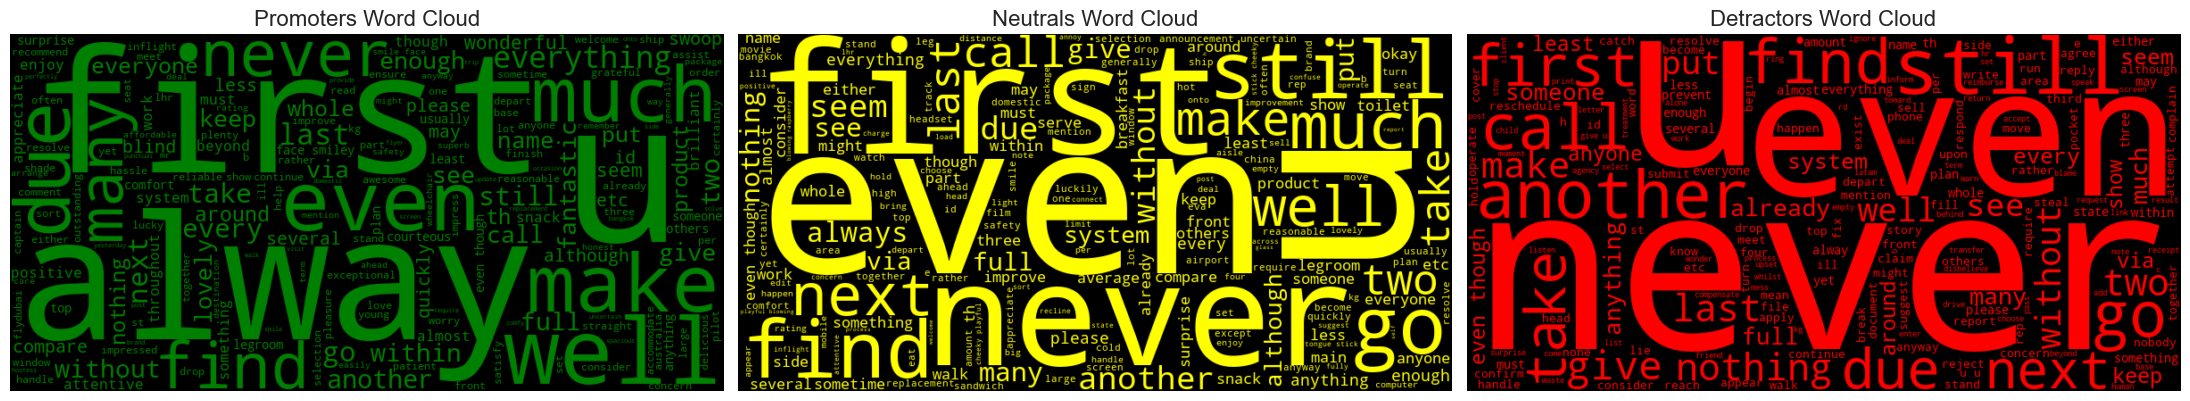

In [46]:
# Create separate DataFrames for Promoters, Detractors, and Neutrals
promoters_df = df[df['NPS_category'] == 'Promoter']
detractors_df = df[df['NPS_category'] == 'Detractor']
neutrals_df = df[df['NPS_category'] == 'Neutral']

def generate_word_cloud(dataframe, title, num, text_color, background_color):
    text = ' '.join(dataframe['clean_text'])
    wordcloud = WordCloud(
        width=800, height=400, background_color=background_color,
        colormap='viridis', color_func=lambda *args, **kwargs: text_color
    ).generate(text)
    plt.subplot(num)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)

plt.figure(figsize=(22, 10))

generate_word_cloud(promoters_df, 'Promoters Word Cloud', 131, 'green', 'black')
generate_word_cloud(neutrals_df, 'Neutrals Word Cloud', 132, 'yellow', 'black')
generate_word_cloud(detractors_df, 'Detractors Word Cloud', 133, 'red', 'black')

plt.tight_layout()
plt.show()

In [ ]:
processed_df.to_csv("karthik_cleaned_data.csv")